# Installs and imports

In [3]:
pip install pandas matplotlib numpy websockets scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Global imports for the game
import websockets
import json
import pandas as pd
import matplotlib.pyplot as plt
from backtest import evaluate

# Task 
### Instructions:
Use the train_data.csv to formulate a trading strategy to trade on assets A,B,C and D. The goal is to aim for the highest possible Sharpe ratio. Market-making and directional strategies (ones that make use of stat-arb/general prediction) are all valid strategies. We will also reward perfect market making - i.e. if you set your bid/ask as the true bid/ask for the next timestep you will be given a payout of spread * min size on bid or ask.

Some rules:
- Your code must pass the timeout constraint of 1 minute to evaluate on our test set
- You are only allowed to use the following libraries in your submission:
    - pandas
    - numpy
    - scikit-learn
- You can only submit one buy and one sell order per asset per timestep (or fewer)
- You can at most be exposed 100 shares of a given asset (i.e. max position is +-100)

In [5]:
# USERNAME (set this to your own)
USERNAME = "JTjust"

In [6]:
# Global variables
SYMBOLS = ["A","B","C","D"]
URL = "ws://34.72.232.39:8765"

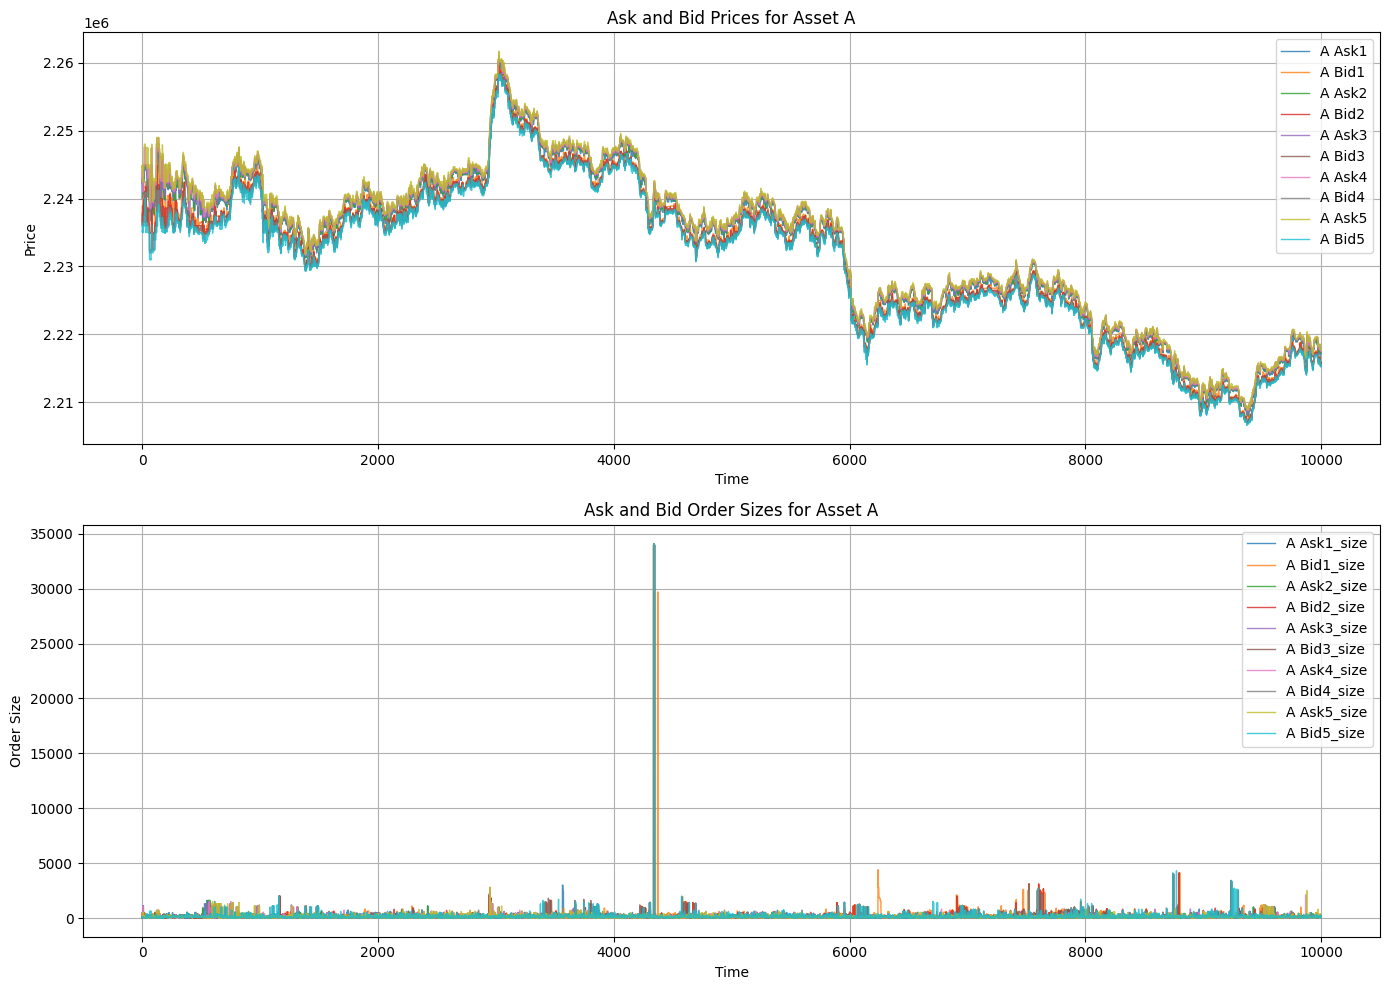

In [14]:
# Train data
train_data = pd.read_csv("train.csv", header=[0, 1], index_col=0)

# Plot Ask and Bid prices for asset A (separated from sizes)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Get all columns for asset A
a_columns = [col for col in train_data.columns if col[0] == 'A']

# Plot prices (Ask1-Ask5, Bid1-Bid5)
for col in a_columns:
    if ('Ask' in col[1] or 'Bid' in col[1]) and '_size' not in col[1]:
        ax1.plot(train_data[col], label=f"A {col[1]}", linewidth=1, alpha=0.8)

ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.set_title('Ask and Bid Prices for Asset A')
ax1.legend(loc='best')
ax1.grid(True)

# Plot sizes (Ask#_size, Bid#_size)
for col in a_columns:
    if '_size' in col[1]:
        ax2.plot(train_data[col], label=f"A {col[1]}", linewidth=1, alpha=0.8)

ax2.set_xlabel('Time')
ax2.set_ylabel('Order Size')
ax2.set_title('Ask and Bid Order Sizes for Asset A')
ax2.legend(loc='best')
ax2.grid(True)

plt.tight_layout()
plt.show()

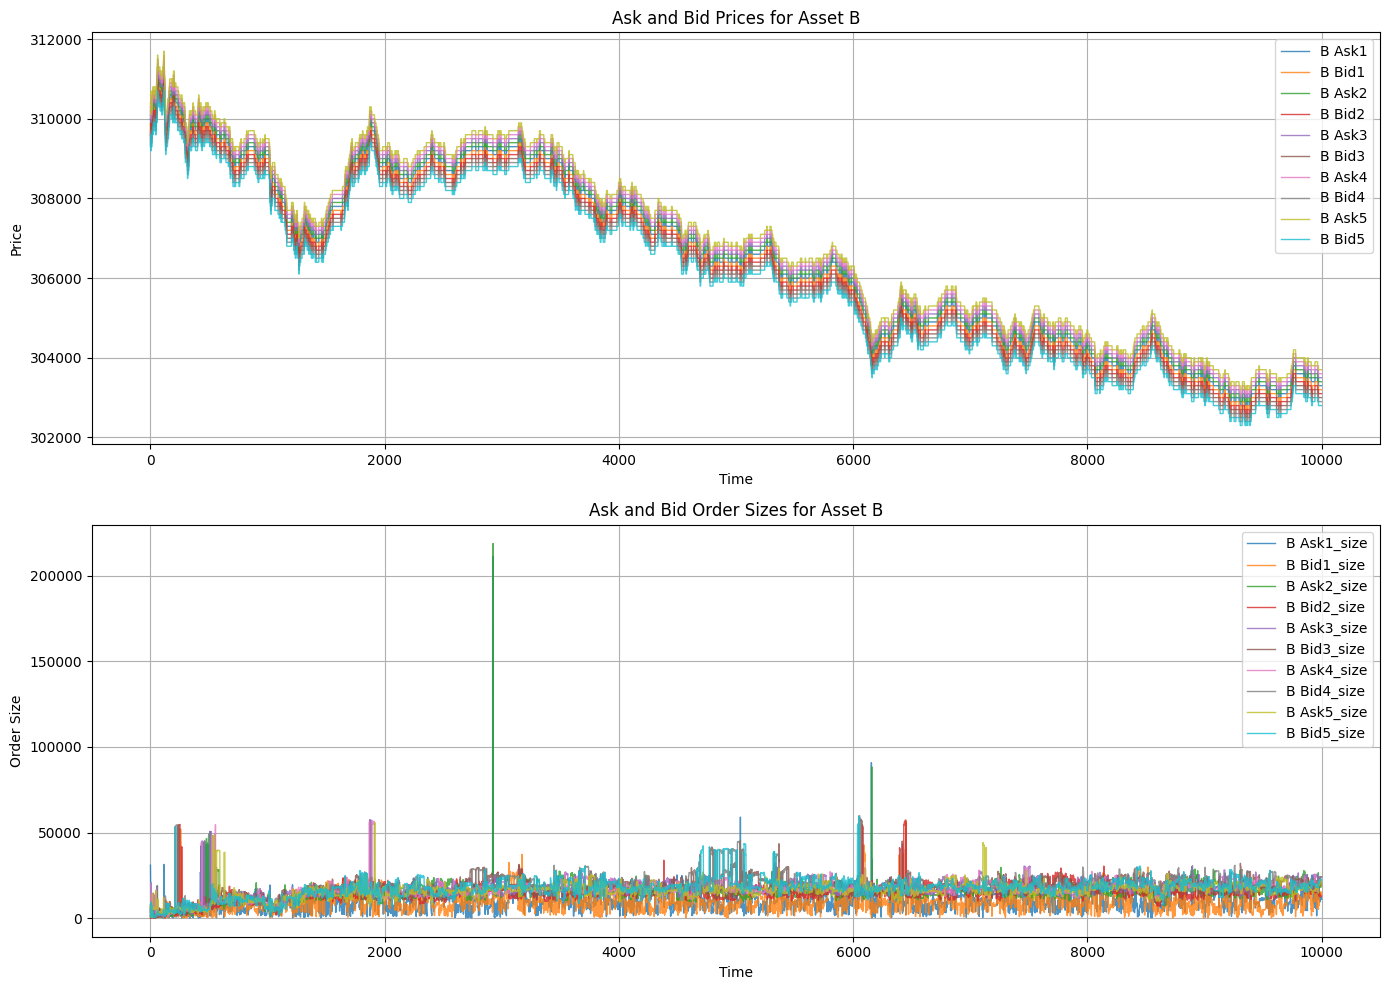

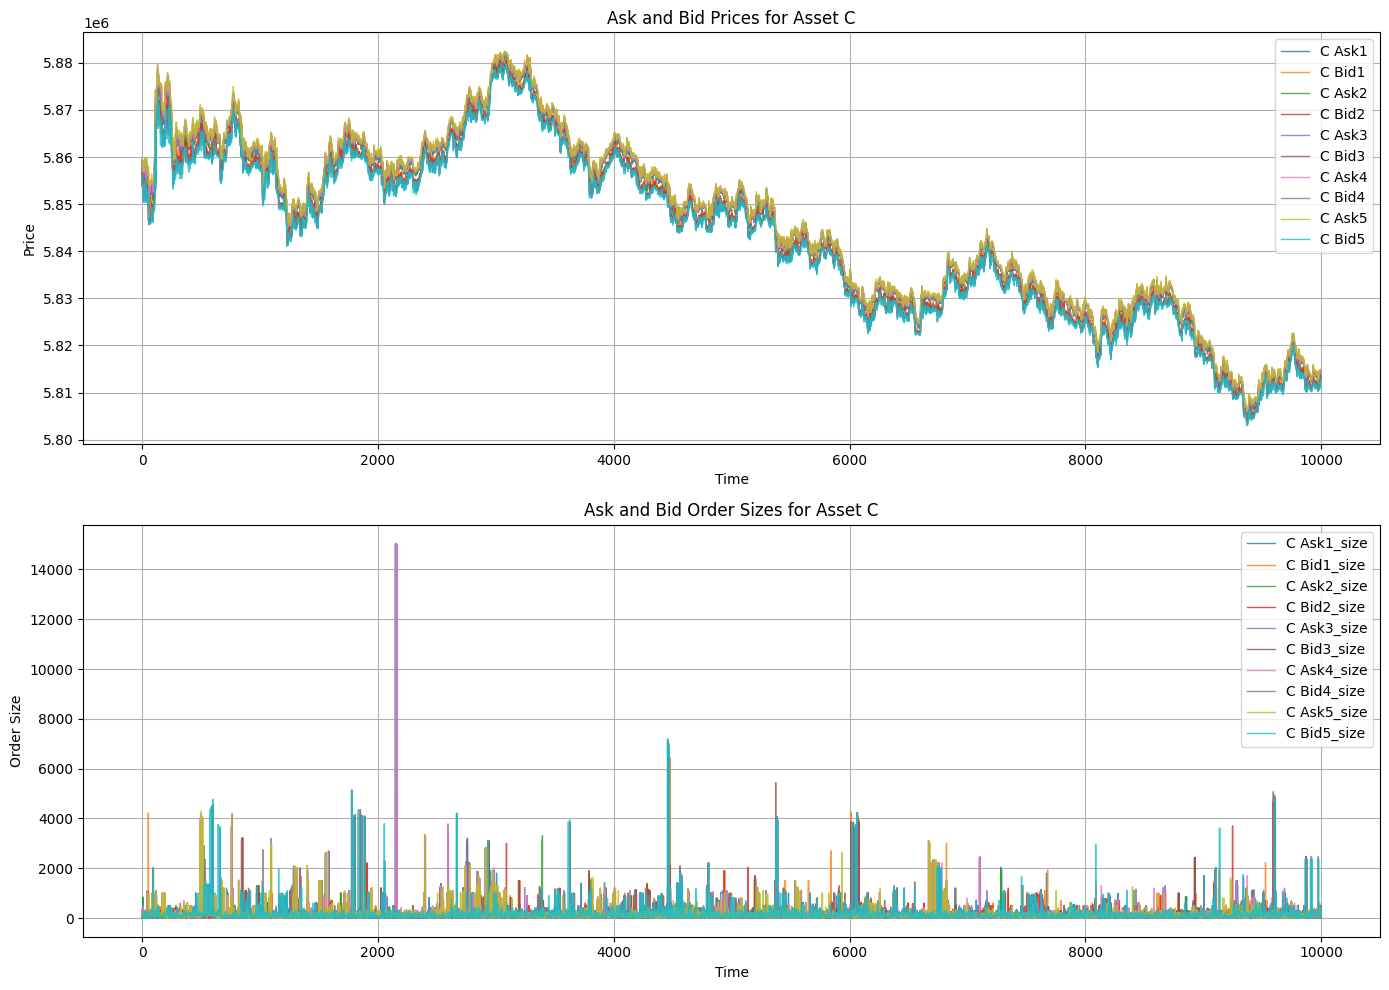

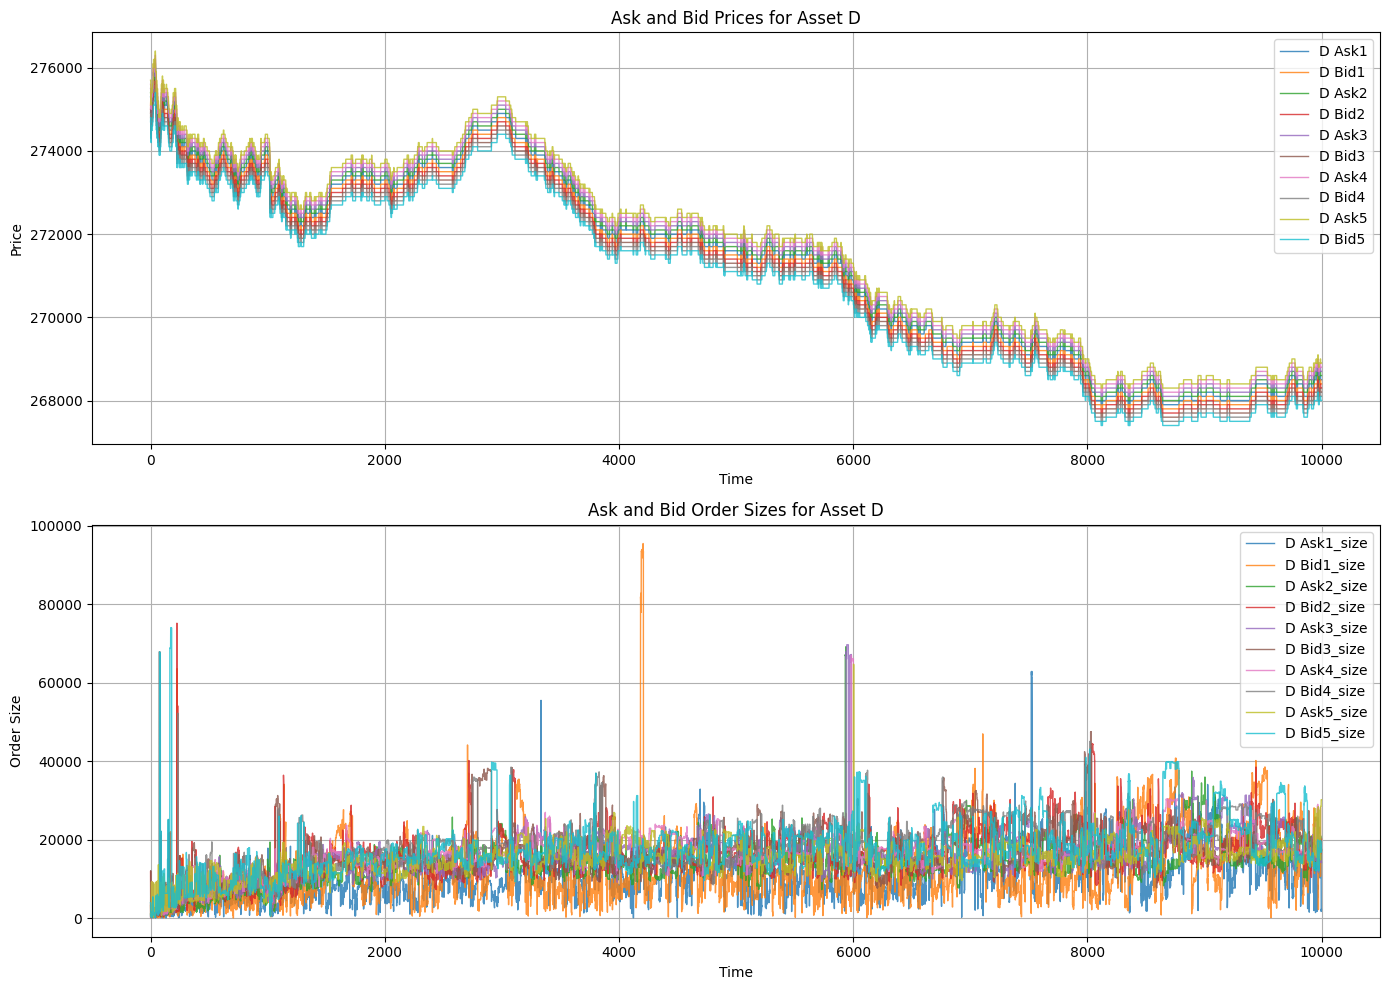

In [15]:
# Plot Ask and Bid prices for assets B, C, D (separated from sizes)
for symbol in ['B', 'C', 'D']:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Get all columns for the symbol
    symbol_columns = [col for col in train_data.columns if col[0] == symbol]
    
    # Plot prices (Ask1-Ask5, Bid1-Bid5)
    for col in symbol_columns:
        if ('Ask' in col[1] or 'Bid' in col[1]) and '_size' not in col[1]:
            ax1.plot(train_data[col], label=f"{symbol} {col[1]}", linewidth=1, alpha=0.8)
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.set_title(f'Ask and Bid Prices for Asset {symbol}')
    ax1.legend(loc='best')
    ax1.grid(True)
    
    # Plot sizes (Ask#_size, Bid#_size)
    for col in symbol_columns:
        if '_size' in col[1]:
            ax2.plot(train_data[col], label=f"{symbol} {col[1]}", linewidth=1, alpha=0.8)
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Order Size')
    ax2.set_title(f'Ask and Bid Order Sizes for Asset {symbol}')
    ax2.legend(loc='best')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

Definition of the orderbook:
```python
class Orderbook:
    def __init__(self):
        self.buy_orders: Dict[int, int] = {} # price : quantity
        self.sell_orders: Dict[int, int] = {} # price : quantity
```
        
Definition of a trade:
```python
class Trade:
    def __init__(self):
        self.price = None
        self.side = None
        self.quantity = None
```

Definition of an order:
```python
class Order:
    def __init__(self, symbol, price, side, quantity):
        self.symbol = symbol
        self.price = price
        self.side = side # 'buy' or 'sell'
        self.quantity = quantity
```

Definition of state:
```python
state = {
    "orderbook": Dict[str, Orderbook],
    "positions": Dict[str, int],
    "trades": Dict[str, Trade]
}
```

In [46]:
# Trader class
from extra_classes import Orderbook, Order, Trade
from typing import Dict, List
import pandas as pd
import numpy as np
import sklearn

class Trader:
    def __init__(self):
        self.window = 15
        self.entry_z = 1.2
        self.exit_z = 0.2
        self.stop_z = 1.5
        self.mid_history = {}
        self.positions = {}
        self.max_positions = 100

    # midprice from top of book
    def mid(self, asset, orderbook):
        best_buy  = max(orderbook[asset].buy_orders.keys())
        best_sell = min(orderbook[asset].sell_orders.keys())
        return (best_buy + best_sell) / 2
    
    def rolling_window(self, symbol, mid):
        history = self.mid_history.setdefault(symbol, [])
        history.append(mid)
        if len(history) > self.window:
            history.pop(0)
        return history
    
    def _z(self, asset):
        history = self.mid_history.get(asset, [])
        if len(history) < self.window:
            return 0
        arr = np.array(history)
        mean = arr.mean()
        std = arr.std() if arr.std() > 1e-9 else 1
        return (arr[-1] - mean) / std
    
    def run(self, state):
        orders: List[Order] = []
        orderbook: Dict[str, Orderbook] = state["orderbook"]
        positions: Dict[str, int] = state["positions"]
        trades: Dict[str, List[Trade]] = state["trades"]

        # sync internal positions with environment
        self.positions = positions.copy()
        for symbol in SYMBOLS:
            if symbol not in self.positions:
                self.positions[symbol] = 0
        
        # Trading logic
        for symbol in SYMBOLS:
            if symbol == "A":
                continue

            middle_price = self.mid(symbol, orderbook)
            self.rolling_window(symbol, middle_price)
            z = self._z(symbol)
            position = self.positions.get(symbol, 0)

            asks = orderbook[symbol].sell_orders
            bids = orderbook[symbol].buy_orders

            ask_price = min(asks.keys()) if asks else None
            bid_price = max(bids.keys()) if bids else None

            # if no valid quotes, skip
            if ask_price is None or bid_price is None:
                continue

            ask_size = asks[ask_price] if ask_price is not None else 0
            bid_size = bids[bid_price] if bid_price is not None else 0
            
            # Skip when the spread is too wide
            spread = ask_price - bid_price
            if spread > 0.005 * middle_price:
                continue

            # Orderbook imbalance filter
            imbalance = 0
            if bid_size + ask_size > 0:
                imbalance = (bid_size - ask_size) / (bid_size + ask_size)

            # ===== Trend / regime filter =====
            skip_longs = False
            skip_shorts = False

            history = self.mid_history.get(symbol, [])
            if len(history) >= self.window:
                recent = np.array(history[-self.window:])
                slope = recent[-1] - recent[0]  # simple trend measure

                # Threshold: ~0.2% move over the window treated as a trend
                trend_threshold = 0.002 * middle_price

                if slope > trend_threshold:
                    # strong uptrend -> avoid opening new shorts
                    skip_shorts = True
                elif slope < -trend_threshold:
                    # strong downtrend -> avoid opening new longs
                    skip_longs = True

            # ========= CUT LOSS LOGIC =========
            # Long position losing: price keeps dropping (Z very negative)
            if position > 0 and z < -self.stop_z:
                size = min(position, bid_size)
                if size > 0:
                    orders.append(Order(symbol, bid_price, "sell", size))
                    self.positions[symbol] -= size

            # Short position losing: price keeps rising (Z very positive)
            elif position < 0 and z > self.stop_z:
                size = min(-position, ask_size)
                if size > 0:
                    orders.append(Order(symbol, ask_price, "buy", size))
                    self.positions[symbol] += size

            # ========= ENTRY LOGIC WITH Z-BASED SIZING =========

            # Buy low when z-score is below -entry_z, imbalance supports buying,
            # and we're not in a strong downtrend filter that blocks longs
            elif (z < -self.entry_z and position < self.max_positions 
                  and imbalance > 0 and not skip_longs):

                # Z-based intensity: 0 at entry_z, 1 at stop_z
                abs_z = abs(z)
                if self.stop_z > self.entry_z:
                    raw_intensity = (abs_z - self.entry_z) / (self.stop_z - self.entry_z)
                else:
                    raw_intensity = 1.0
                intensity = max(0.0, min(1.0, raw_intensity))

                # target size to ADD this tick
                target_add = int(self.max_positions * intensity)
                # don’t exceed remaining long capacity
                max_add_by_pos = self.max_positions - position
                size = min(target_add, max_add_by_pos, ask_size)

                if size > 0:
                    orders.append(Order(symbol, ask_price, "buy", size))
                    self.positions[symbol] += size
            
            # Sell high when z-score is above entry_z, imbalance supports selling,
            # and we're not in a strong uptrend filter that blocks shorts
            elif (z > self.entry_z and position > -self.max_positions 
                  and imbalance < 0 and not skip_shorts):

                abs_z = abs(z)
                if self.stop_z > self.entry_z:
                    raw_intensity = (abs_z - self.entry_z) / (self.stop_z - self.entry_z)
                else:
                    raw_intensity = 1.0
                intensity = max(0.0, min(1.0, raw_intensity))

                # target size to ADD on the short side this tick
                target_add = int(self.max_positions * intensity)
                # remaining short capacity (how much more we can sell)
                max_add_by_pos = self.max_positions + position  # since position is <= 0 for big shorts
                size = min(target_add, max_add_by_pos, bid_size)

                if size > 0:
                    orders.append(Order(symbol, bid_price, "sell", size))
                    self.positions[symbol] -= size

            # ========= PARTIAL PROFIT-TAKING / NORMAL EXIT =========
            elif abs(z) < self.exit_z and position != 0:
                # Take partial profit: close about half the position
                if position > 0:
                    # long: sell half at bid
                    target_close = max(1, int(position * 0.5))
                    size = min(target_close, bid_size)
                    if size > 0:
                        orders.append(Order(symbol, bid_price, "sell", size))
                        self.positions[symbol] -= size

                elif position < 0:
                    # short: buy back half at ask
                    target_close = max(1, int(-position * 0.5))
                    size = min(target_close, ask_size)
                    if size > 0:
                        orders.append(Order(symbol, ask_price, "buy", size))
                        self.positions[symbol] += size

        return orders


In [47]:
# This is a backtesting cell on the train set. 
# Run it before submitting to check for errors and how long it takes to run your code.
# If it falls under a minute then you are safe to submit.

# Remember to rerun the trader cell before running the submission cell.
evaluate(Trader())

'Final train PnL: -66015500.0'

In [45]:
# Submission cell 
""" INSTRUCTIONS:
To submit, run the cell with your "Trader class" code AND THEN this block in that order. 

The way this block works is that it uses ipython's environment variable _i to 
get access to the code as a string so that it can be sent 
to the virtual machine and run to instantiate your custom Trader logic.
The code will fail otherwise.
"""

async with websockets.connect(URL) as ws:
    await ws.send(json.dumps({"user": USERNAME,"code": _i}))
    message = await ws.recv()
    async for msg in ws:
        print("Received:", msg)
        msg = json.loads(msg)
        if isinstance(msg, list):
            msg = msg[0]
        if msg["result"]:
            break

Received: {"message": "Exception: name 'Trader' is not defined", "result": true}
